# Predicting Sensor Data using Multiple Linear Regression and Neural Networks

This Jupyter notebook is a showcase of the INCD cloud services. It presents a case study similar to the one presented by (Mata, 2011), which makes a comparison between Multiple Linear Regression (MLR) and Neural Networks (NN) predictions of dam behaviour under environment loads.
In this case, an adapted dataset of a Portuguese dam will be used, containing information about Displacement manual readings on a specific dam sector. Environmental variables are also available in the dataset, such as water level (H), air temperatures (cos(d) + sen(d), being d the day of the year) and time (t, dam's age in days). The date of the readings is registered as well.

To manually run the following cells, use Shift + Enter.

To run all cells use the menu "Run" -> "Run All Cells".

To restart use the menu "Kernel" -> "Restart Kernel and Clear All Outputs...".

## Imports

Python has libraries that facilitate the use of data structures (such as numpy and pandas), the creation of plots (matplotlib) and the utilization of Machine Learning models, such as MLR and NN, or pre-processing tools (sklearn). These libraries are imported in the cell below. To have reproducibility of results, a random seed is also set below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor

np.random.seed(50)

## Import Dataset

The first step of the script is to import the dataset into a table. Using pandas package, the dataset is imported from a CSV file. The predictors and the response are defined in the cell below, as well as the path for the CSV file.

In [25]:
datasetloc = "../data/dataset.csv"
dateColumn = 'date'
predictors = ['H', 'H2', 'H3', 'H4', 'SinD', 'CosD', 'T']
response = 'D'

In [26]:
df = pd.read_csv(datasetloc, sep=',')
df[dateColumn] = pd.to_datetime(df[dateColumn])
df.set_index(dateColumn, inplace=True)
df.head()

,D,H,H2,H3,H4,SinD,CosD,T
date,,,,,,,,
1993-03-18,3.52,63.84,4075.5456,260182.831104,1.661007e+07,0.97,0.24,433
1993-03-29,3.52,64.61,4174.4521,269711.350181,1.742605e+07,1.00,0.06,444
1993-04-12,3.24,65.87,4338.8569,285800.504003,1.882568e+07,0.98,-0.18,458
1993-04-26,2.05,69.23,4792.7929,331805.052467,2.297086e+07,0.91,-0.41,472
1993-05-11,2.68,69.79,4870.6441,339922.251739,2.372317e+07,0.77,-0.63,487


The following command shows statistical information about the dataset.

In [27]:
df.describe()

,D,H,H2,H3,H4,SinD,CosD,T
count,653.000000,653.000000,653.000000,653.000000,6.530000e+02,653.000000,653.000000,653.000000
mean,5.088182,66.245931,4420.752234,297031.371988,2.008535e+07,0.006662,-0.003354,5034.477795
std,4.867314,5.681398,736.974065,72367.474676,6.371165e+06,0.708165,0.707593,2665.605050
min,-5.300000,47.880000,2292.494400,109764.631872,5.255531e+06,-1.000000,-1.000000,433.000000
25%,1.140000,62.370000,3890.016900,242620.354053,1.513223e+07,-0.710000,-0.700000,2726.000000
50%,4.360000,66.871000,4471.730641,299029.099694,1.999637e+07,0.050000,-0.010000,5036.000000
75%,9.190000,70.630000,4988.596900,352344.599047,2.488610e+07,0.720000,0.700000,7339.000000
max,15.210000,76.370000,5832.376900,445418.623853,3.401662e+07,1.000000,1.000000,9642.000000


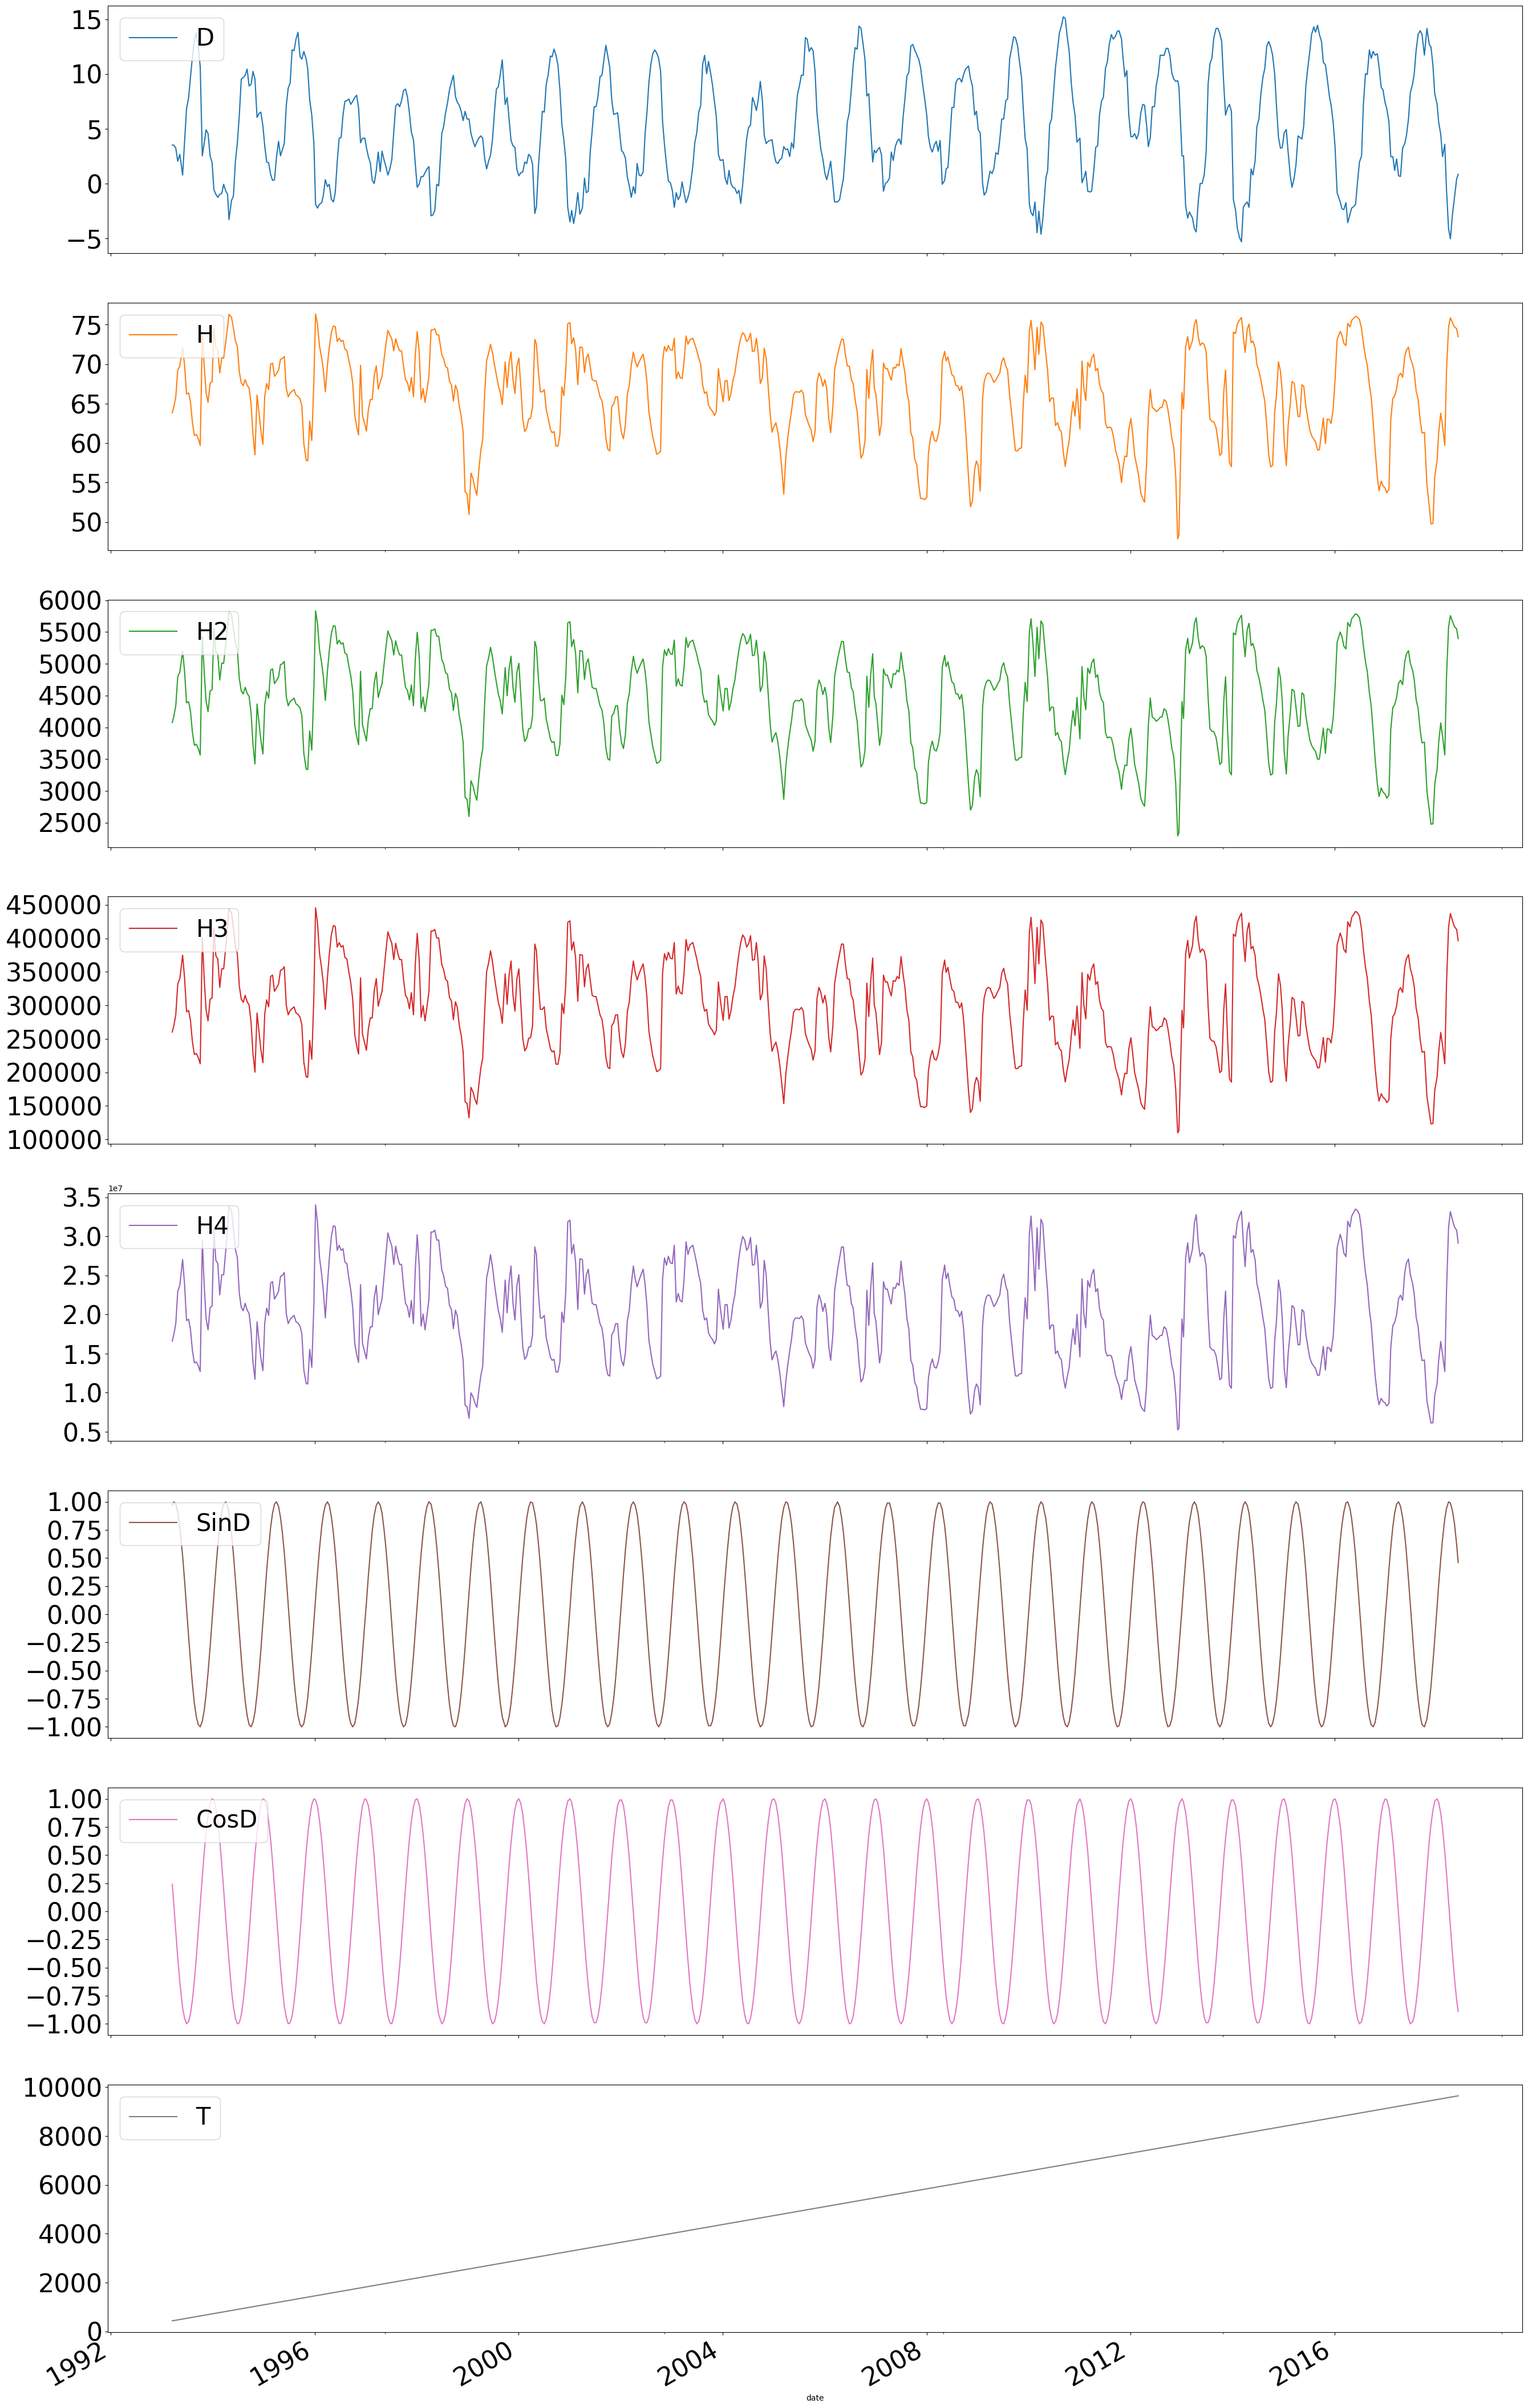

In [24]:
df.plot(subplots=True, sharex=True, sharey=False, figsize=(32, 60), fontsize=32)
[ax.legend(loc = 2, fontsize = 30) for ax in plt.gcf().axes];

## Standardization

In Machine Learning it is a good practice to normalize or standardize the dataset before fitting models to it. This is done to reduce bias towards some variables (predictors have different scales) and to allow or ease the model fitting (NN for example can't stabilize in a non-standardized dataset). The following standardization will leave each predictor variable with 0 mean and standard deviation of 1. The response does not need to be standardized.
Below a boxplot with the predictors variables is presented and one will be presented in the end to demonstrate the standardization effect.

Preditors' boxplots before standardization: 


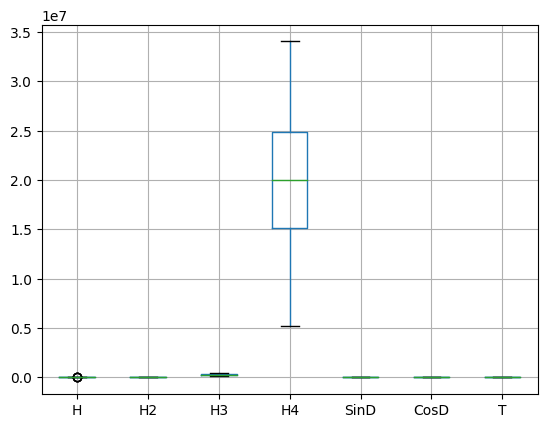

In [28]:
print("Preditors' boxplots before standardization: ")
df[predictors].boxplot();

The following steps are taken in the cell below:

1) The predictors are retrieved from the dataset and standardized using the StandardScaler from sklearn's preprocessing tools;

2) The standardized predictors are stored within a dataframe with the correct column names;

3) The predictors' columns are replaced by the standardized predictors in the original dataset.

In [29]:
#1
X = df[predictors].values
stdscaler = preprocessing.StandardScaler()
X_scaled = stdscaler.fit_transform(X)

#2
scaledDf = pd.DataFrame(X_scaled)
scaledDf.columns = predictors

#3
for var in predictors:
    df[var] = np.array(scaledDf[var])

Preditors' boxplots after standardization.


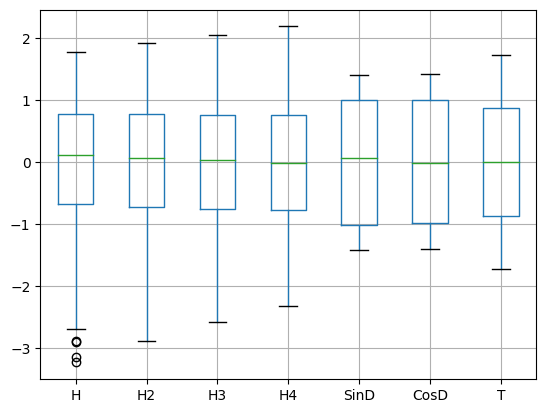

In [30]:
print("Preditors' boxplots after standardization.")
df[predictors].boxplot();

In [31]:
df.describe()

,D,H,H2,H3,H4,SinD,CosD,T
count,653.000000,6.530000e+02,6.530000e+02,6.530000e+02,6.530000e+02,6.530000e+02,6.530000e+02,6.530000e+02
mean,5.088182,1.588656e-15,-3.373174e-16,-3.046738e-16,-4.026046e-16,-1.088121e-17,-3.944437e-17,8.704965e-17
std,4.867314,1.000767e+00,1.000767e+00,1.000767e+00,1.000767e+00,1.000767e+00,1.000767e+00,1.000767e+00
min,-5.300000,-3.235121e+00,-2.890046e+00,-2.589703e+00,-2.329431e+00,-1.422596e+00,-1.409582e+00,-1.727565e+00
25%,1.140000,-6.827373e-01,-7.207068e-01,-7.524475e-01,-7.780233e-01,-1.012773e+00,-9.852845e-01,-8.666878e-01
50%,4.360000,1.101046e-01,6.922562e-02,2.762649e-02,-1.397588e-02,6.124511e-02,-9.399958e-03,5.714921e-04
75%,9.190000,7.722448e-01,7.710990e-01,7.649241e-01,7.540897e-01,1.008077e+00,9.947711e-01,8.652027e-01
max,15.210000,1.783334e+00,1.916902e+00,2.052041e+00,2.188289e+00,1.403768e+00,1.419069e+00,1.729834e+00


## Divide Dataset into Train, Validation and Test 

Now that the dataset is standardized, the next step is to obtain the Train, Validation and Test sets. Since the dataset contains manual readings, which are done once every two weeks (generally), the test set contains the last 24 readings (data points), corresponding to approximately a year of data. The validation set was composed by 48 readings (aprox. two years) prior to the test set, with the training set containing the remainder of the data.

The fitting of Machine Learning models is done using the training set, which contains the historical information of the variable. The validation dataset is used in the parameterization of the models, allowing the model to be tweaked in order to better deal with unknown information (as will be shown in the NN parameterization process). In the end, the test set is used to obtain a prediction with never seen data, allowing a realistic evaluation on how the model deals with new data.

Each of the sets are also divided into an X (containing the predictors information) and y (containing the response) datasets. The division is done to facilitate the posterior fitting and evaluation of the models. So X_train corresponds to the predictors of the training set, and so on.

In [32]:
df_train, df_validation, df_test = df[:-72], df[-72:-24], df[-24:]
X_train, y_train = df_train[predictors], df_train[response]
X_validation, y_validation = df_validation[predictors], df_validation[response]
X_test, y_test = df_test[predictors], df_test[response]

Below two plots are presented:

The first plot contains the response variable divided by sets. The validation set is shown in red and the test set is presented in green.

The second plot is a zoomed version of the first, only containing the validation and test sets.

In [37]:
type(df_validation[response])

pandas.core.series.Series

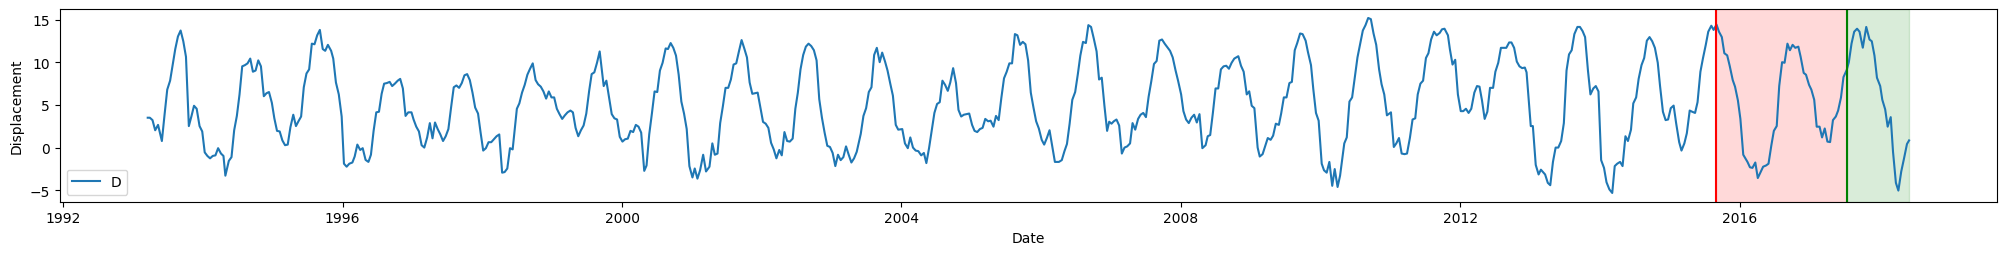

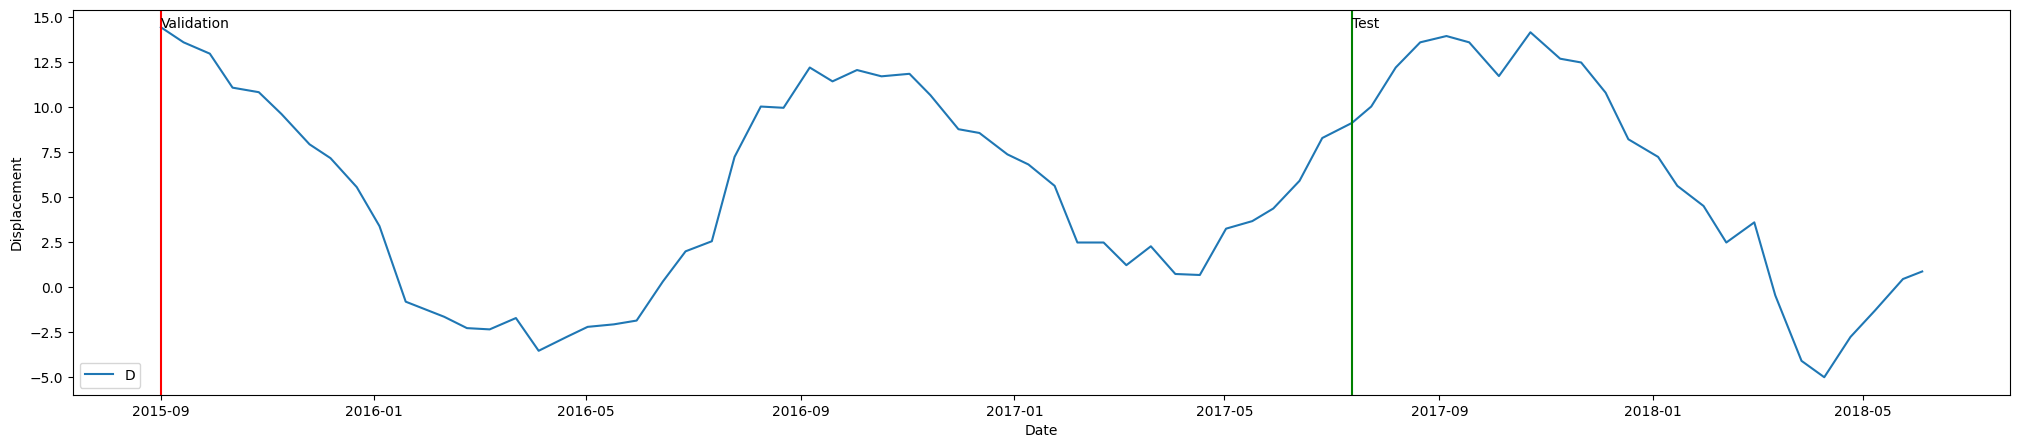

In [42]:
#First plot
fig, ax = plt.subplots(figsize=(25,2.5))
ax.plot(df[response], label=response)

plt.ylabel("Displacement")
plt.xlabel("Date")

plt.axvline(x=df_validation.first_valid_index(), color='r')
plt.axvline(x=df_test.first_valid_index(), color='g')
plt.axvspan(df_validation.first_valid_index(),df_test.first_valid_index(), alpha=0.15,  color='r')
plt.axvspan(df_test.first_valid_index(), df_test.last_valid_index(), alpha=0.15,  color='g')
legend = ax.legend(loc='lower left', shadow=False)

plt.show()

#Second plot
fig, ax = plt.subplots(figsize=(25,5))
#ax.plot(df_validation[response].append(df_test[response]), label=response) Deprecated
ax.plot(pd.concat([df_validation[response], (df_test[response])]), label=response)

plt.text(df_validation.first_valid_index(), max(df_validation[response]), 'Validation', fontsize=10)
plt.text(df_test.first_valid_index(), max(df_validation[response]), 'Test', fontsize=10)

plt.ylabel("Displacement")
plt.xlabel("Date")

plt.axvline(x=df_validation.first_valid_index(), color='r')
plt.axvline(x=df_test.first_valid_index(), color='g')
legend = ax.legend(loc='lower left', shadow=False)

plt.show()

## Multiple Linear Regression

The first model presented is the Multiple Linear Regression (MLR). With the help of sklearn's library, the MLR model is fitted using the training set. After the fitting, information about the models's intercept and coefficients is easily retrieved as seen below.

In [43]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
print('Intercept: ' + str(model.intercept_))
for i in range(len(predictors)):
    print(predictors[i] + ": " + str(model.coef_[i]))

Intercept: 5.01153738559113
H: -114.72009088949504
H2: 376.96722692293724
H3: -408.9949948693824
H4: 144.23234407143997
SinD: -2.9370690516741575
CosD: -1.8906378417916656
T: 0.15454092692159094


In this case, the validation set doesn't have a purpose due the lack of parameterization in the MLR model. With this in mind, predictions for both validations and test set are done in order to retrieve  some metrics for further comparison. The following steps are taken:

1) The trained model is used to obtain a prediction by giving information about the predictors (X);

2) Metrics like Mean Squared Error (MSE) and Mean Absolute Error (MAE) can be retrieved from the comparison between the real values of the response (y);

3) The plot of predicted values against the real values is obtained.

In this case, the steps were done for both the validation and test sets.

Validation Prediction Errors
Mean quadratic error 1.3437512363636464
Mean absolute error 0.9386431962471616


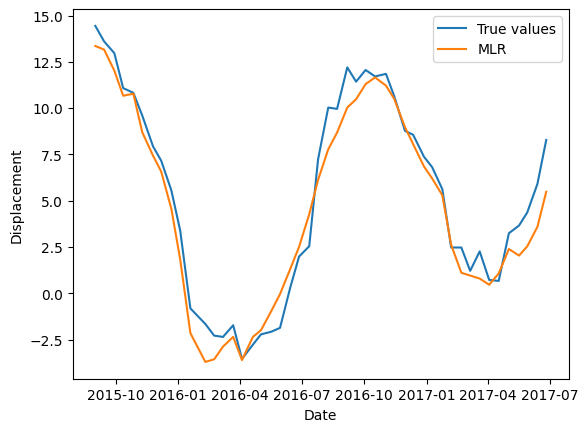

In [44]:
#1
MLRValPred = pd.Series(data=model.predict(X_validation), index=y_validation.index)

#2
errors = MLRValPred-y_validation
mse = errors.pow(2).mean()
mae = errors.abs().mean()
print("Validation Prediction Errors")
print("Mean quadratic error", mse)
print("Mean absolute error", mae)

#3
fig, ax = plt.subplots()
ax.plot(y_validation, label='True values')
ax.plot(MLRValPred, label='MLR')
plt.ylabel("Displacement")
plt.xlabel("Date")
ax.legend(loc='upper right', shadow=False)
plt.show()

Test Prediction Errors
Mean quadratic error 1.9000497012516193
Mean absolute error 1.1520855748383878


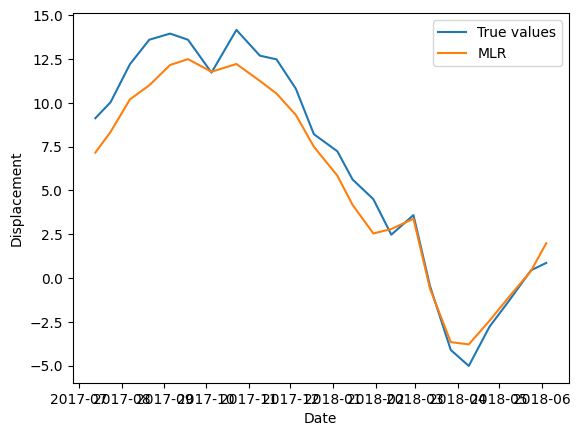

In [45]:
#1
MLRTestPred = pd.Series(data=model.predict(X_test), index=y_test.index)

#2
errors = MLRTestPred-y_test
mse_MLR = errors.pow(2).mean()
mae = errors.abs().mean()
print("Test Prediction Errors")
print("Mean quadratic error", mse_MLR)
print("Mean absolute error", mae)

#3
fig, ax = plt.subplots()
ax.plot(y_test, label='True values')
ax.plot(MLRTestPred, label='MLR')
plt.ylabel("Displacement")
plt.xlabel("Date")
ax.legend(loc='upper right', shadow=False)
plt.show()

Train Prediction Errors
Mean quadratic error 1.004806263114196
Mean absolute error 0.7955846279172152


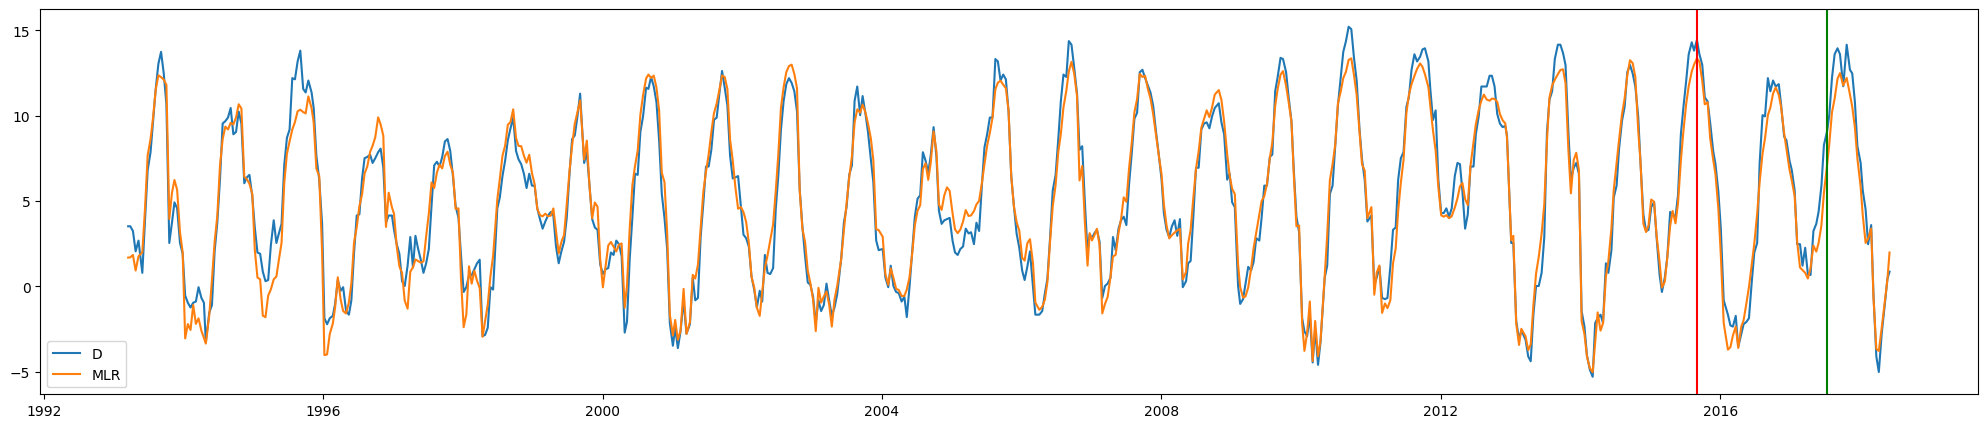

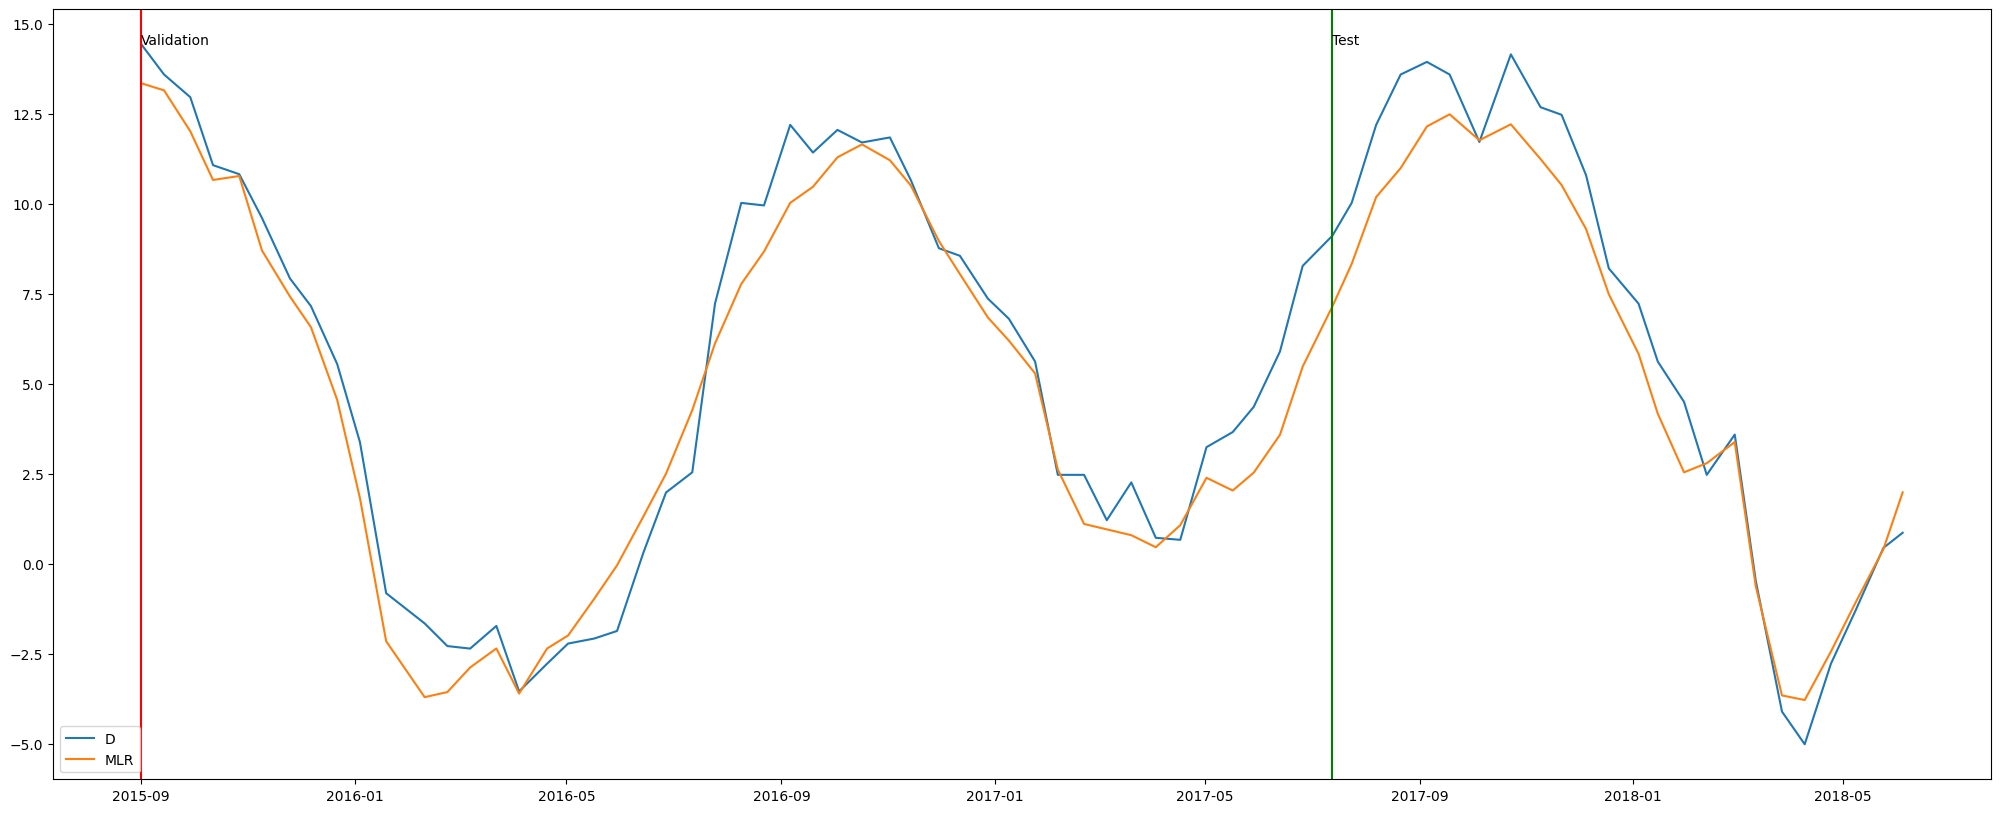

In [51]:
#Training Prediction for plotting
MLRTrainPred = pd.Series(data=model.predict(X_train), index=y_train.index)
errors = MLRTrainPred-y_train
mse = errors.pow(2).mean()
mae = errors.abs().mean()
print("Train Prediction Errors")
print("Mean quadratic error", mse)
print("Mean absolute error", mae)

#First plot
fig, ax = plt.subplots(figsize=(25,5))
ax.plot(df[response], label=response)
ax.plot(pd.concat([MLRTrainPred, MLRValPred, MLRTestPred]), label = 'MLR')

plt.axvline(x=df_validation.first_valid_index(), color='r')
plt.axvline(x=df_test.first_valid_index(), color='g')
legend = ax.legend(loc='lower left', shadow=False)

plt.show()

#Second plot
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(pd.concat([df_validation[response], df_test[response]]), label=response)
ax.plot(pd.concat([MLRValPred, MLRTestPred]), label = 'MLR')

plt.text(df_validation.first_valid_index(), max(df_validation[response]), 'Validation', fontsize=10)
plt.text(df_test.first_valid_index(), max(df_validation[response]), 'Test', fontsize=10)

plt.axvline(x=df_validation.first_valid_index(), color='r')
plt.axvline(x=df_test.first_valid_index(), color='g')
legend = ax.legend(loc='lower left', shadow=False)

plt.show()

## Neural Network

Using Neural Networks (NN) model leads to a very different process when compared to the MLR. Like said before, NN have a set of parameters that can directly impact the model fitting process. In this showcase, two of the NN parameters will be tested:

1) Hidden Layer Size: The NN models will only use one hidden layer, leading to a model with a input layer with n nodes (being n the number of predictors), an output layer with one node (the response) and an hidden layer in between with an uncertain number of nodes. To define the size of this layer, three different sizes are tested: n, n*2+1 (Mata, 2011) and 100 (default value from sklearn).

2) Maximum Iterations: The NN fitting is an iterative process that, if left untouched, can lead to an overfitted model (which normally have difficulties when leading with new information, not perfect for a predictive scenario). To avoid this, the NN model has a max_iter parameter that stops the fitting process. We want a model that is able to accurately predict new information. To discover when we are more likely to obtain such model, we will analyze the fitting process, collecting metrics for each iteration and selecting a max_iter value that should do the job.

Before going forward please read the following:

The NN fitting has a random factor to it (the initial weights are random). So when doing only one fitting, the result can be either the best model possible or the worst, or something in between. To effectively draw conclusions, a set of fittings should be done in order to increase the confidence in the tests (in this showcase, 10 fittings will be done). A simple fitting of a NN is done below, using the sklearn's Multi-layer Perceptron with the default parameters, followed by a prediction in the validation test. Run the cell (Ctrl + Enter) as many times as you want, and you can observe that the MSE from the validation isn't always the same.


In [52]:
model = MLPRegressor()
trainedmodel = model.fit(X_train, y_train)
prediction = pd.Series(data=model.predict(X_validation), index=y_validation.index)
print("MSE: " + str((prediction-y_validation).pow(2).mean()))

MSE: 0.7255329926789309


c:\sw\python\dataScienceIntro\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


For each of the values that will be testing for the hidden_layer_sizes (#1), 10 NN models will be trained using the training set (#2). Each of this models will obtain a prediction using the validation set (#3) and a MSE of the prediction is retrieved (#4). In the end, minimum, mean, maximum and standard deviation values for the MSE are obtained for each of the  hidden_layer_sizes tested (#5).

(*) The default value of max_iter from MLPRegressor in the sklearn package is 200. We change this value to a much higher one in order to allow the NN to converge, and obtaining the real potential of the hidden layer size. The overfitting problematic is tackled next.

In [53]:
n = len(predictors)

#1
for nodes in [n, n*2-1, 100]: 
    mse = []
    for i in range(10):
        
        #2
        model = MLPRegressor(hidden_layer_sizes=(nodes), max_iter = 2000) # (*) see above
        trainedmodel = model.fit(X_train, y_train)
        
        #3
        prediction = pd.Series(data=model.predict(X_validation), index=y_validation.index)
        
        #4
        mse.append((prediction-y_validation).pow(2).mean())
    #5
    print("MSE with NN's hidden_layer_size of: " + str(nodes))
    print("min: " + str(np.min(mse)) + "; mean: " + str(np.mean(mse)) + "; std: " + str(np.std(mse)) + "; max: " + str(np.max(mse)))

MSE with NN's hidden_layer_size of: 7
min: 0.8158158126264171; mean: 1.1196676727031096; std: 0.20134589633917566; max: 1.4592156369764417
MSE with NN's hidden_layer_size of: 13
min: 0.7405044680100549; mean: 0.9531638858128803; std: 0.1563216495898034; max: 1.2813275608222041
MSE with NN's hidden_layer_size of: 100
min: 1.103397373864113; mean: 1.48055591181383; std: 0.27562012460584623; max: 2.014656211062818


Now that a satisfying hidden layer size was found (can be changed in the cell below), the following step is finding a maximum iteration parameter to avoid overfitting. Contrary to the previous test, obtaining metrics when the NN is fully converged is not the objective, the metrics should be retrieved during the fitting process. To achieve this, MSE for test (to see if we are overfitting) and validation (to ensure the model can predict with accuracy unseen data) is retrieved during each of the 2000 iterations of the fitting process. In the end, a plot is obtained that illustrates the evolution of the prediction performance of the model in the test and validation sets. The process is repeated 10 times for reasons previously explained.

In [54]:
#best hidden_layer_size
bestHLS = n*2-1

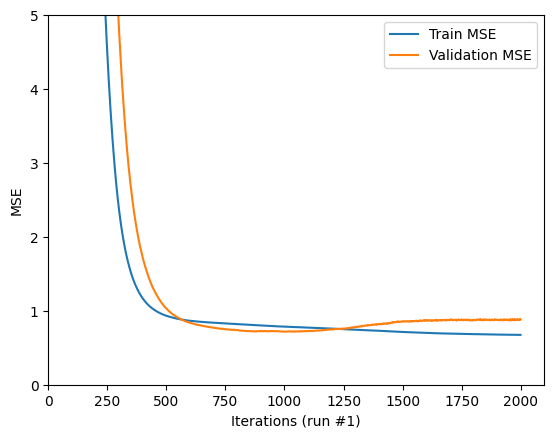

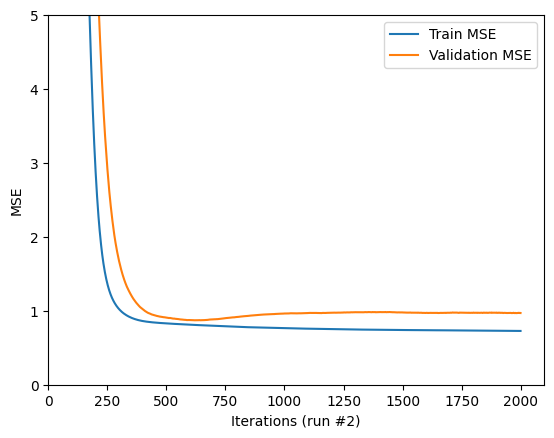

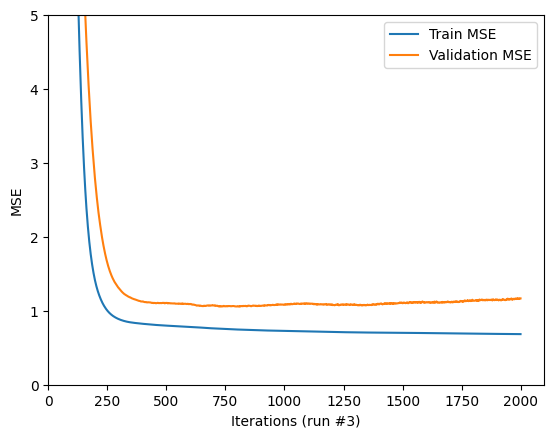

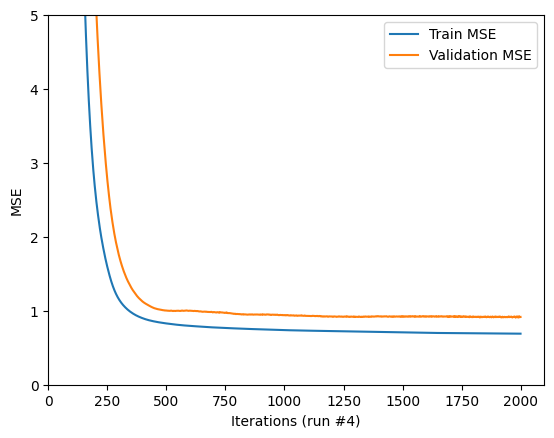

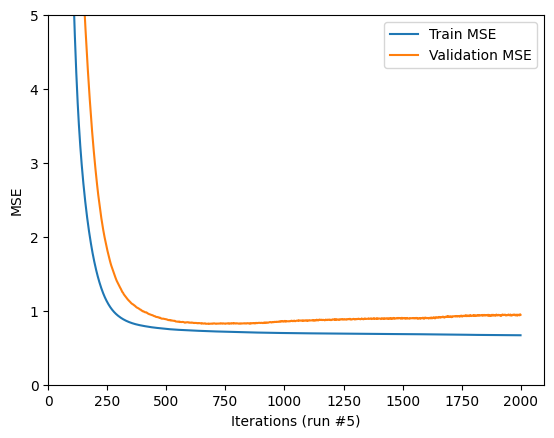

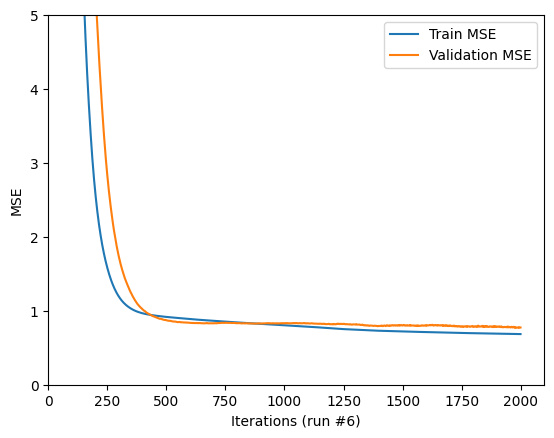

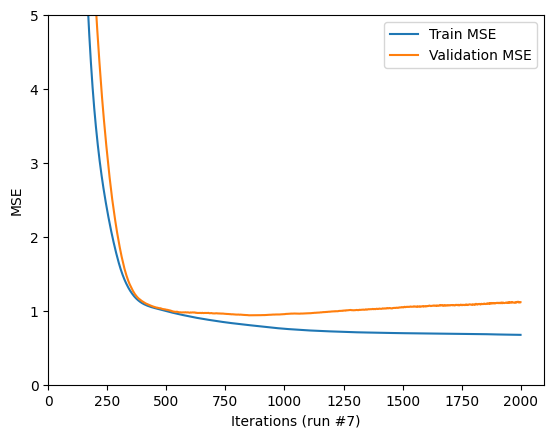

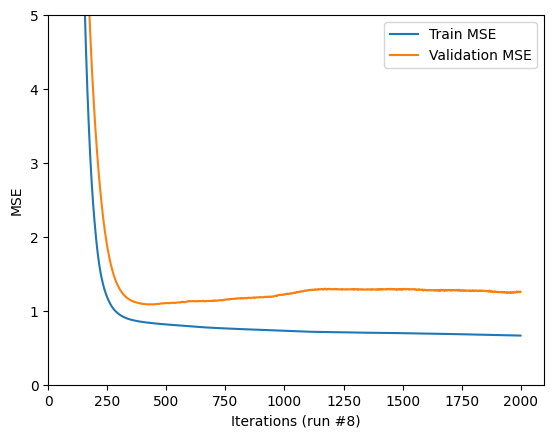

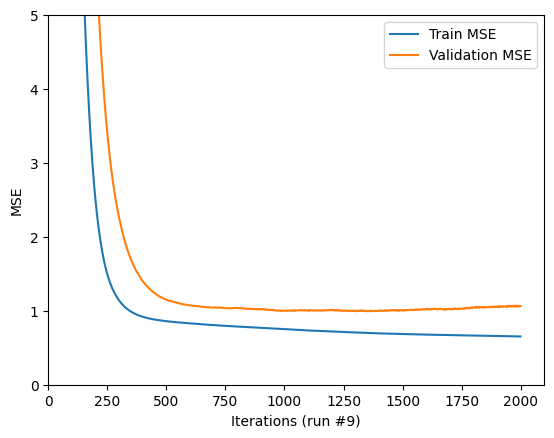

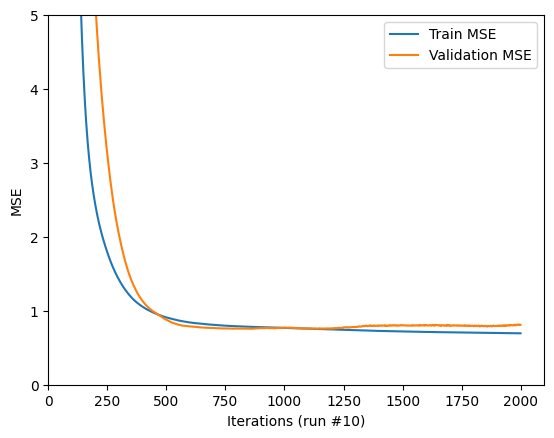

In [55]:
for i in range(1,11):
    model = MLPRegressor(hidden_layer_sizes=bestHLS, max_iter=2000)
    tmse = []
    vmse = []
    for j in range(2000):
        trainedmodel = model.partial_fit(X_train, y_train)
        
        prediction = pd.Series(data=model.predict(X_train), index=y_train.index)
        tmse.append((prediction-y_train).pow(2).mean())
        
        prediction = pd.Series(data=model.predict(X_validation), index=y_validation.index)
        vmse.append((prediction-y_validation).pow(2).mean())
   
    fig, ax = plt.subplots()
    ax.plot(tmse, label='Train MSE')
    ax.plot(vmse, label='Validation MSE')
    ax.set_ylim(bottom = 0, top=5)
    ax.set_xlim(0)
    legend = ax.legend(loc='upper right', shadow=False)
    plt.ylabel("MSE")
    plt.xlabel(f"Iterations (run #{i})")
    plt.show()

In [56]:
#best maximum_iteration
max_iteration = 500

Finally, now that the NN parameters are set, we can proceed with the model evaluation. The NN will be again fitted using the training set, and evaluations will be done using the test set prediction. The MSE results presended are in respect of the 10 models, while the plotted values are only from the last fitted model.

c:\sw\python\dataScienceIntro\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\sw\python\dataScienceIntro\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\sw\python\dataScienceIntro\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\sw\python\dataScienceIntro\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\sw\python\dataScienceIntr

Mean Squared Error
min: 0.6962584836002409; mean: 1.0983063419016397; std: 0.22785218179329367; max: 1.5237667824144616


c:\sw\python\dataScienceIntro\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


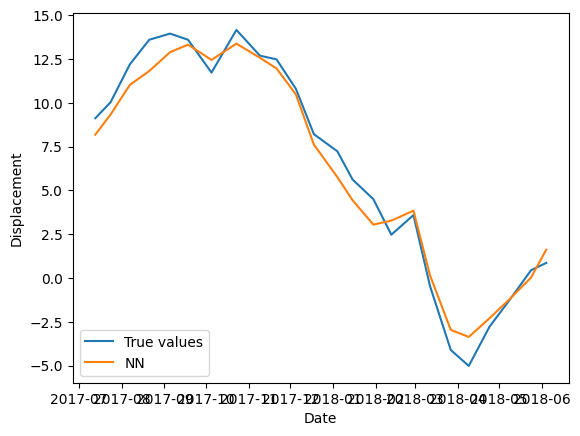

In [57]:
mse = []
for i in range(10):
    model = MLPRegressor(hidden_layer_sizes = bestHLS, max_iter=max_iteration)
    trainedmodel = model.fit(X_train, y_train)
    
    prediction = pd.Series(data=model.predict(X_test), index=y_test.index)
    mse.append((prediction-y_test).pow(2).mean())
    
print("Mean Squared Error")
print("min: " + str(np.min(mse)) + "; mean: " + str(np.mean(mse)) + "; std: " + str(np.std(mse)) + "; max: " + str(np.max(mse)))    

mse_NN = np.mean(mse)

fig, ax = plt.subplots()
ax.plot(y_test, label='True values')
ax.plot(prediction, label='NN')
plt.ylabel("Displacement")
plt.xlabel("Date")
ax.legend(loc='lower left', shadow=False)
plt.show()

## Results Comparison

Now that the evaluation is complete, we can compare the MLR against the NN, looking at the MSE improvement and looking at the predicted values (see plot below)!

In [58]:
improv = (mse_MLR-mse_NN)*100/mse_MLR

print('MLR MSE Result: ' + str(mse_MLR))
print('NN MSE Result: ' + str(mse_NN))
print('NN MSE Improvement vs MLR ' + str(improv))

MLR MSE Result: 1.9000497012516193
NN MSE Result: 1.0983063419016397
NN MSE Improvement vs MLR 42.19591512905412


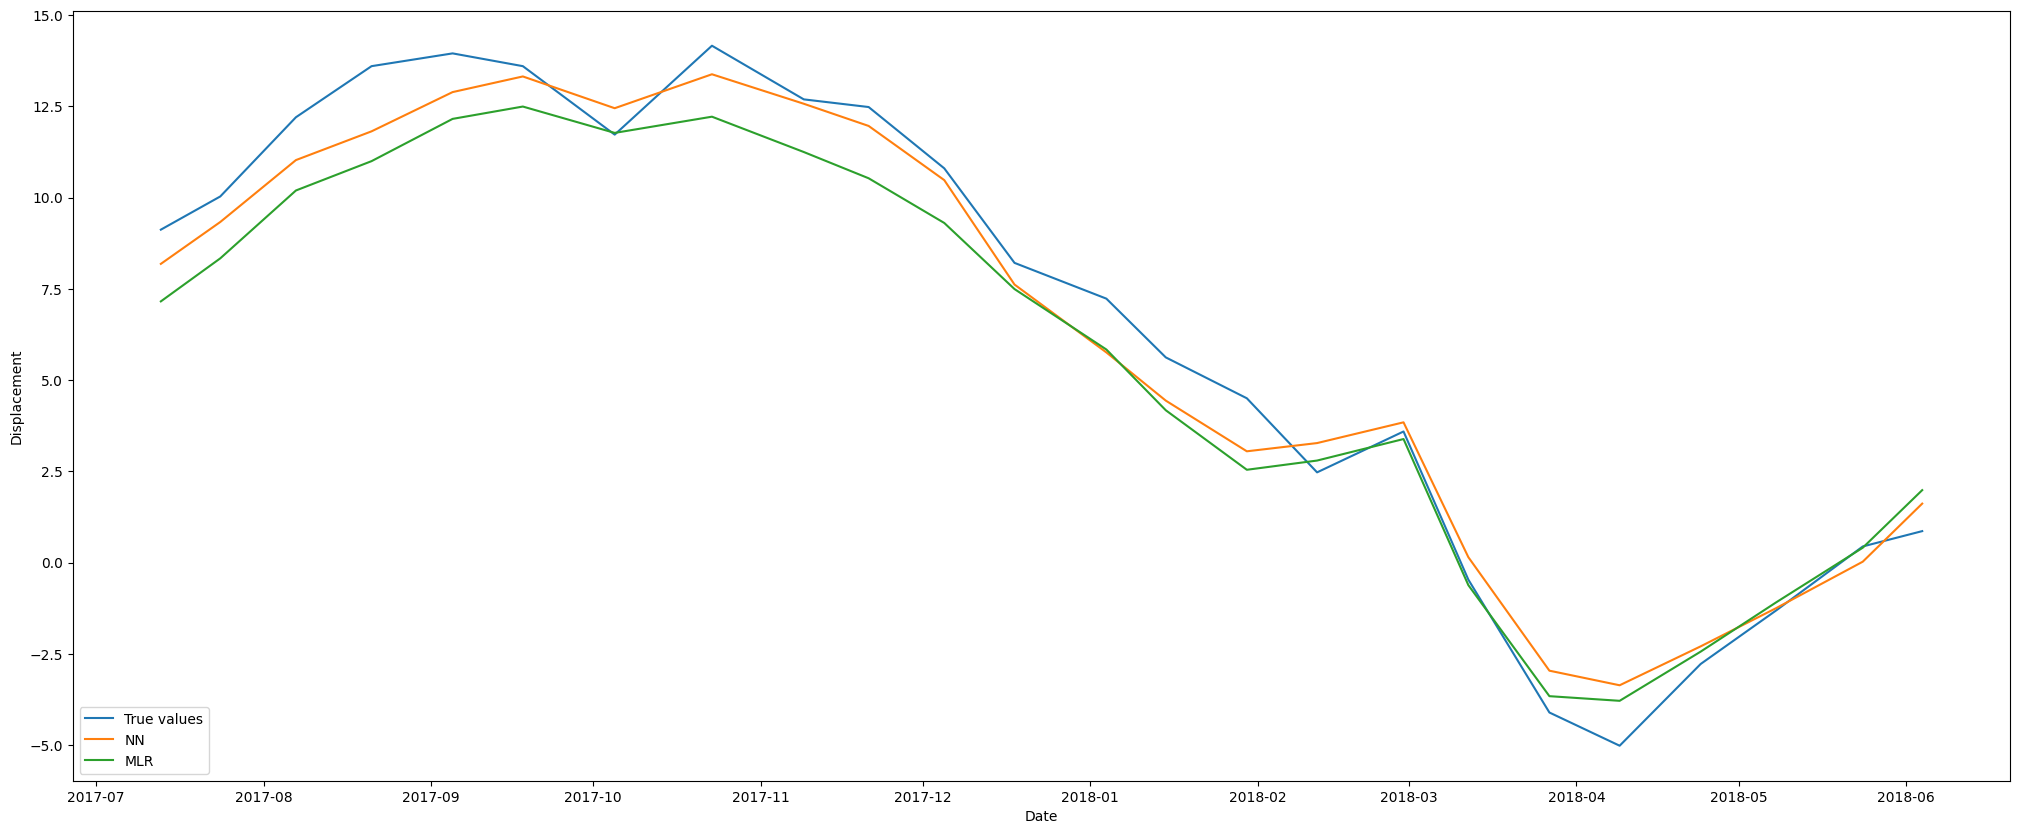

In [59]:
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(y_test, label='True values')
ax.plot(prediction, label='NN')
ax.plot(MLRTestPred, label='MLR')
plt.ylabel("Displacement")
plt.xlabel("Date")
ax.legend(loc='lower left', shadow=False)
fig.savefig("results.pdf")
plt.show()

## References

Mata, J. (2011). Interpretation of concrete dam behaviour with artificial neural network and multiple linear regression models. Engineering Structures, 33(3), 903-910.